# Section II: Programming

## Part I: Cluster Validity (15 point)

In [ ]:
import scipy.optimize
import scipy.sparse
import numpy as np
from math import log
from sklearn.metrics import adjusted_rand_score, silhouette_score


def contingency_matrix(ground_truth: np.ndarray, prediction: np.ndarray,
                       sparse: bool = False) -> scipy.sparse.csr.csr_matrix:
    """

    :param ground_truth:
    :param prediction:
    :param sparse:
    :return:
    """

    classes, class_idx = np.unique(ground_truth, return_inverse=True)
    clusters, cluster_idx = np.unique(prediction, return_inverse=True)
    n_classes, n_clusters = classes.shape[0], clusters.shape[0]
    contingency = scipy.sparse.coo_matrix((np.ones(class_idx.shape[0]), (class_idx, cluster_idx)),
                                          shape=(n_classes, n_clusters), dtype=np.int)

    if sparse:
        contingency = contingency.tocsr()
        contingency.sum_duplicates()
    else:
        contingency = contingency.toarray()

    return contingency


def entropy(labels: np.ndarray) -> float:
    """

    :param labels:
    :return:
    """

    if len(labels) == 0:
        return 1.0

    label_idx = np.unique(labels, return_inverse=True)[1]
    pi = np.bincount(label_idx).astype(np.float64)
    pi = pi[pi > 0]
    pi_sum = np.sum(pi)

    return -np.sum((pi / pi_sum) * (np.log(pi) - log(pi_sum)))


def cluster_accuracy(ground_truth: np.ndarray, prediction: np.ndarray, cluster_number: int = None) -> tuple:
    """
    Calculate clustering accuracy using the linear_sum_assignment function (based on hungary algorithm)
    in SciPy to determine reassignments.

    :param ground_truth: true cluster numbers, an integer array 0-indexed
    :param predicted: predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters
    :return: reassignment dictionary, clustering accuracy
    """

    assert ground_truth.shape == prediction.shape

    if cluster_number is None:
        cluster_number = max(ground_truth.max(), prediction.max()) + 1
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)

    for i in range(prediction.size):
        count_matrix[prediction[i], ground_truth[i]] += 1

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / prediction.size

    return reassignment, accuracy


def mutual_info_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    MI(U, V) = sum(P(i, j) * log(P(i, j) / P(i)P'(j)))

    :param ground_truth:
    :param prediction:
    :return:
    """

    contingency = contingency_matrix(ground_truth, prediction, sparse=True)
    nzx, nzy, nz_val = scipy.sparse.find(contingency)
    contingency_sum = contingency.sum()
    pi = np.ravel(contingency.sum(axis=1))
    pj = np.ravel(contingency.sum(axis=0))
    log_contingency_nm = np.log(nz_val)
    contingency_nm = nz_val / contingency_sum
    # for non-zeros
    outer = (pi.take(nzx).astype(np.int64, copy=False) * pj.take(nzy).astype(np.int64, copy=False))
    log_outer = -np.log(outer) + log(pi.sum()) + log(pj.sum())
    mi = (contingency_nm * (log_contingency_nm - log(contingency_sum)) + contingency_nm * log_outer)

    return mi.sum()


def normalized_mutual_info_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """
    Normalized mutual information between two clustering results.
    NMI(U, V) = MI(U, V) / mean(H(U), H(V))

    :param ground_truth: true cluster numbers, an integer array 0-indexed
    :param prediction: predicted cluster numbers, an integer array 0-indexed
    :return: normalized mutual information score, 0 -> no mutual information; 1 -> perfect correlation
    """

    assert ground_truth.shape == prediction.shape

    classes, clusters = np.unique(ground_truth), np.unique(prediction)
    if (classes.shape[0] == clusters.shape[0] == 1 or classes.shape[0] == clusters.shape[0] == 0):
        return 1.0

    mi = mutual_info_score(ground_truth, prediction)
    h_true, h_pred = entropy(ground_truth), entropy(prediction)
    # arithmetic normalized
    normalizer = max(np.mean([h_true, h_pred]), np.finfo('float64').eps)
    nmi = mi / normalizer

    return nmi


def _adjusted_rand_score(ground_truth: np.ndarray, prediction: np.ndarray) -> float:
    """

    :param ground_truth:
    :param prediction:
    :return:
    """

    assert ground_truth.shape == prediction.shape

    return adjusted_rand_score(ground_truth, prediction)


def _silhouette_score(X: np.ndarray, prediction: np.ndarray) -> float:
    """

    :param X:
    :param prediction:
    :return:
    """

    assert X.shape[0] == prediction.shape[0]

    return silhouette_score(X, prediction)


## Part II: K-Means Clustering

In [97]:
## importing packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

## loading data
three_globs = pd.read_csv('/Users/tjmask/Desktop/Semester 2/Data Mining/HW1/hw1/Homework_1/Datasets/three_globs.csv')
three_globs = np.array(three_globs)
three_globs[0:5]

array([[-7.8803e-01,  4.9875e-02],
       [-6.6334e-01, -2.2204e-16],
       [-7.5312e-01, -4.9875e-03],
       [-4.9377e-01, -1.4963e-02],
       [-8.2294e-01, -1.9950e-02]])

### Implementing K-means

In [99]:
## loading packages 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [152]:
#euclidian distance between 2 data points. 
def euclidian(a, b):
    return np.linalg.norm(a-b)

def kmeans(k, epsilon=0.001, distance='euclidian', dataset=None):
    #list to store old centroid
    history_centroids = []
    #set the distance calculation type 
    if distance == 'euclidian':
        dist_method = euclidian
    ## converting data into array
    dataset = np.array(dataset)
    # get the number of rows (instances) and columns (features) from the dataset
    num_instances, num_features = dataset.shape
    # initialize k centroids chosen randomly 
    prototypes = dataset[np.random.randint(0, num_instances - 1, size=k)] ## k*2 matrix
    #set these to our list of past centroid (to show progress over time)
    history_centroids.append(prototypes)
    #to keep track of centroid at every iteration
    prototypes_old = np.zeros(prototypes.shape) ## k*2 matrix
    #to store clusters
    belongs_to = np.zeros((num_instances, 1)) ## n*1 matrix
    norm = dist_method(prototypes, prototypes_old) 
    iteration = 0
    while norm > epsilon:
        iteration += 1
        norm = dist_method(prototypes, prototypes_old)
        #for each instance in the dataset
        for index_instance, instance in enumerate(dataset):
            #define a distance vector of size k
            dist_vec = np.zeros((k,1))
            #for each centroid
            for index_prototype, prototype in enumerate(prototypes): ## 2*1 
                #compute the distance between x and centroid
                dist_vec[index_prototype] = dist_method(prototype, instance)
            #find the smallest distance, assign that distance to a cluster
            belongs_to[index_instance, 0] = np.argmin(dist_vec) ## the location
#         print(iteration, "=================", norm)
        tmp_prototypes = np.zeros((k, num_features)) ## k*2 matrix
        
        # update centriods for each cluster
        for index in range(k):
            #get all the points assigned to a cluster
            instances_close = [i for i in range(len(belongs_to)) if belongs_to[i] == index]
            #find the mean of those points, this is our new centroid
            prototype = np.mean(dataset[instances_close], axis=0)
            #add our new centroid to our new temporary list
            tmp_prototypes[index, :] = prototype
#         print(iteration, "--------------------")
        #set the new list to the current list
        prototypes = tmp_prototypes
        
        #add our calculated centroids to our history for plotting
        history_centroids.append(tmp_prototypes)

    #return calculated centroids, history of them all, and assignments for which cluster each datapoint belongs to
    return prototypes, history_centroids, belongs_to

In [157]:
prototypes, history_centroids, belongs_to = kmeans(k=3, epsilon=1.06, distance='euclidian', dataset= three_globs)
# belongs_to

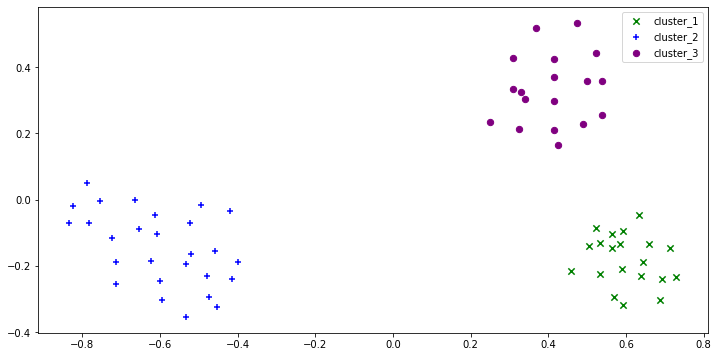

In [158]:
## visualization 
plt.figure(figsize=(12,6))
status_1 = np.where(belongs_to ==0)[0]
status_2 = np.where(belongs_to ==1)[0]
status_3 = np.where(belongs_to ==2)[0]
plt.scatter(three_globs[status_1,0],three_globs[status_1,1],  marker = 'x',color = 'green', s = 40,label = 'cluster_1')
plt.scatter(three_globs[status_2,0],three_globs[status_2,1],  marker = '+',color = 'blue', s = 40,label = 'cluster_2')
plt.scatter(three_globs[status_3,0],three_globs[status_3,1],  marker = 'o',color = 'purple', s = 40,label = 'cluster_3')
plt.legend(loc='upper right')

### Evaluate Performance

## Part III: DBSCAN(15 point）

### 1. Implementing DBSCAN

In [ ]:
# step 1: identify core points and its neighbors
# step 2: grow cluster
# step 3: label each points, -1 for noise

In [39]:
## loading data
anthill = pd.read_csv('/Users/tjmask/Desktop/Semester 2/Data Mining/HW1/hw1/Homework_1/Datasets/anthill.csv')
anthill = np.array(anthill)

In [58]:
import numpy as np
import math

## first we need to find the noise 
'''
there are two threshold to define a noise, the density and radius. Density can be 
thought as how many points does this point can have with given radius. When the distances
between the choosen point with other points are less than the given radius, then the other
points should be included in the choosen point's density. If the total number of included 
points are larger than or equal to the min number of points(threshold, hyperparameters),we say it's a 
core point. while the total number of included points are less than the min number of points, 
we can it broder points. And the others are noise, and should be removed while we are doing clustering.
'''
## get the distance between two points
def dist(p,q):
    return math.sqrt(np.power(p-q,2).sum())

## find if the distance is less than given radius
def neighborhood(p,q,radius):
    return dist(p,q) < radius

## find all neighbors of a point
def regionScan(dataset, P, radius):
    neighbors = []
    # For each point in the dataset...
    for x in range(0, len(dataset)):
        if neighborhood(dataset[P], dataset[x], radius):
            neighbors.append(x)
    return neighbors

def growCluster(dataset, labels, P, NeighborPts, C, radius, MinPts):

    # Assign the cluster label to the seed point.
    labels[P] = C
    
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
            labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = regionScan(dataset, Pn, radius)
             
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
            else:               
                NeighborPts = NeighborPts               
        i += 1  

                
def DBSCAN(dataset, radius, MinPts):
    labels = [0]*len(dataset)    
    C = 0
    
    for P in range(0, len(dataset)):
        if not (labels[P] == 0):
            continue
        
        NeighborPts = regionScan(dataset, P, radius)
        if len(NeighborPts) < MinPts:
            labels[P] = -1    
        else: 
            C += 1
            growCluster(dataset, labels, P, NeighborPts, C, radius, MinPts)
    return labels      

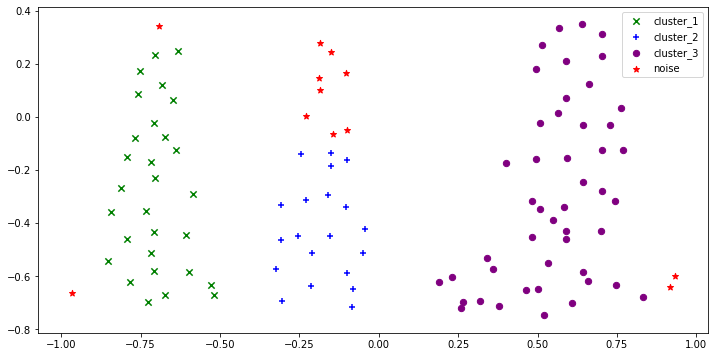

In [80]:
labels = DBSCAN(anthill, 0.2,10)
labels = np.array(labels)
data = anthill 
## visualiztion
plt.figure(figsize=(12,6))
plt.scatter(data[labels==1,0],data[labels==1,1],  marker = 'x',color = 'green', s = 40,label = 'cluster_1')
plt.scatter(data[labels==2,0],data[labels==2,1],  marker = '+',color = 'blue', s = 40,label = 'cluster_2')
plt.scatter(data[labels==3,0],data[labels==3,1],  marker = 'o',color = 'purple', s = 40,label = 'cluster_3')
plt.scatter(data[labels==-1,0],data[labels==-1,1],marker = '*',color = 'red', s = 40,label = 'noise')
plt.legend(loc='upper right')

### Evaluate Performance

In [42]:
import numpy as np
import math

## first we need to find the noise 
'''
there are two threshold to define a noise, the density and radius. Density can be 
thought as how many points does this point can have with given radius. When the distances
between the choosen point with other points are less than the given radius, then the other
points should be included in the choosen point's density. If the total number of included 
points are larger than or equal to the min number of points(threshold, hyperparameters),we say it's a 
core point. while the total number of included points are less than the min number of points, 
we can it broder points. And the others are noise, and should be removed while we are doing clustering.
'''
## get the distance between two points
def dist(p,q):
    return math.sqrt(np.power(p-q,2).sum())


## find if the distance is less than given radius
def neighborhood(p,q,radius):
    return dist(p,q) < radius

## determine the status of all points(core, broder, noise)
def status(dataset, radius, minPts):
    point_status = np.zeros([len(dataset),1])
    core = set()
    for i in range(0, len(dataset)):
        total_points = []
        for j in range(0, len(dataset)):
            if neighborhood(dataset[i], dataset[j],radius):
                total_points.append(j)
        if len(total_points) >= minPts:
            point_status[i] = 2    ## 2 is the status of core point
            core.add(i)         ## get the all the core points
    ## determine border and noise points       
    for x in range(0, len(point_status)):
        if point_status[x] ==0:
            for y in range(0, len(dataset)):
                if neighborhood(dataset[x], dataset[y],radius) and point_status[y]==2:
                    point_status[x] = 1   ## 1 is the status of border point 
    
#     core = set([i for i in range(data.shape[0]) if len(dic[i]) >= m_points])
    return point_status, core


def scan(x, radius,dataset, minPts):
    total_status, sub_core = status(dataset, radius, minPts)
    temp_points = []
    temp_status = []
    for i in range(0,len(dataset)):
        if neighborhood(dataset[x], dataset[i],radius):
            temp_points.append(i)
            temp_status.append(total_status[i])
            temp_status = [i for i in temp_status if i==2]
    return temp_status, temp_points, sub_core



def dbscan(dataset,radius, minPts):
    total_status, total_core = status(dataset, radius, minPts)
    classification = np.zeros([len(dataset),1]); label=1
    while (len(total_core)) > 0:
        for x in total_core:
            scan(x,radius, dataset, minPts)
            total_core = total_core-sub_score
            while True:
                if len(sub_core)<0:
                    classification[[temp_points]]=label
                    break
                else:
                    for z in temp_point:
                        scan(z, radius, dataset, minPts)
                        if 
                        
    
    
    
    
    
    for x in range(0, len(total_status)):
        print('==========',x)
        cluster += 1 
        if total_status[x] ==0:
            classification[x] = None
        elif total_status[x]==2:
            ## first round scan 
            scan(x, radius, dataset, minPts)
            while True:
                print('---------',cluster)
                if not any((temp_status)):
                    classification[[temp_points]]=cluster
                    break
                else:
                    while True:
                        for z in temp_points:
                            scan(z,radius, dataset,minPts)
#                         classification[z]=cluster
                            if not any((temp_status)):
                                break
                            else:
                                scan(z,radius, dataset,minPts) 
            
    return classification           

In [55]:
# status(anthill, 0.2,10)
a  = set(1)
if len(a):
    print(1)

TypeError: 'int' object is not iterable

In [36]:
l = np.zeros([3,1])
set(l)

TypeError: unhashable type: 'numpy.ndarray'

In [416]:
mm = status(np.array(anthill)[30:40], 0.2, 5)
print(mm)
cluster = 0
classification = np.zeros([len(mm),1])
for x in range(0, len(mm)):
        cluster += 1 
        if mm[x] ==0:
            classification[x] = None
        elif mm[x]==2:
            classification[x]=cluster
classification

[[0.]
 [2.]
 [2.]
 [1.]
 [1.]
 [2.]
 [1.]
 [0.]
 [2.]
 [2.]]


array([[nan],
       [ 2.],
       [ 3.],
       [ 0.],
       [ 0.],
       [ 6.],
       [ 0.],
       [nan],
       [ 9.],
       [10.]])

In [434]:
dbscan(np.array(anthill)[20:40], radius=0.2, minPts=5)
# status(np.array(anthill)[20:40], radius=0.2, minPts=5)

========== 0
========== 1
========== 2
========== 3
--------- 4
========== 4
========== 5
========== 6
========== 7
--------- 8
========== 8
========== 9
========== 10
========== 11
--------- 12
========== 12
--------- 13
========== 13
========== 14
========== 15
--------- 16
========== 16
========== 17
========== 18
--------- 19
========== 19
--------- 20


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [nan],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [nan],
       [ 0.],
       [ 0.]])

In [377]:
np.array(anthill)[1:20]

array([[-0.85287 , -0.54364 ],
       [-0.84289 , -0.3591  ],
       [-0.81297 , -0.26933 ],
       [-0.79302 , -0.45885 ],
       [-0.79302 , -0.14963 ],
       [-0.78304 , -0.62344 ],
       [-0.76808 , -0.0798  ],
       [-0.70808 , -0.5798  ],
       [-0.71808 , -0.5118  ],
       [-0.7581  ,  0.084788],
       [-0.75312 ,  0.17456 ],
       [-0.73317 , -0.35411 ],
       [-0.72818 , -0.69825 ],
       [-0.7182  , -0.16958 ],
       [-0.70823 , -0.43392 ],
       [-0.70823 , -0.024938],
       [-0.70324 , -0.22943 ],
       [-0.70324 ,  0.23441 ],
       [-0.69327 ,  0.34414 ]])

In [435]:
# dbscan(np.array(anthill), radius=0.2, minPts=10)
scan(np.array(anthill), radius=0.2, minPts=10)
def scan(x,radius,dataset):
    temp_points = []
    temp_status = []
    for i in range(0,len(dataset)):
        if neighborhood(dataset[x], dataset[i],radius):
            temp_points.append(i)
            temp_status.append(point_status[i])
            temp_status = [n for n in temp_status if n==2]
    return temp_status, temp_points




# # point_status = np.zeros([3,1])
# # point_status[0]=1
# a[[0,1]] = 3
# a
# x = [1,2,3]
# x = [i for i in x if i==4]
# if  any((x)):
#     print(111,x)
    


TypeError: scan() missing 1 required positional argument: 'dataset'

In [182]:
import numpy as np
import math

UNCLASSIFIED = False
NOISE = 'Noise'

def _dist(p,q):
    return math.sqrt(np.power(p-q,2).sum())

def _eps_neighborhood(p,q,eps):
    return _dist(p,q) < eps

def _region_query(dataset, point_id, eps):
    n_points = dataset.shape[0]
    seeds = []
    for i in range(0, n_points):
        if _eps_neighborhood(dataset[point_id], dataset[i], eps):
            seeds.append(i)
    return seeds

def _expand_cluster(dataset, classifications, point_id, cluster_id, eps, min_points):
    seeds = _region_query(dataset, point_id, eps)
    if len(seeds) < min_points:
        classifications[point_id] = NOISE
        return False
    else:
        classifications[point_id] = cluster_id
        for seed_id in seeds:
            classifications[seed_id] = cluster_id
            
        while len(seeds) > 0:
            current_point = seeds[0]
            results = _region_query(dataset, current_point, eps)
            if len(results) >= min_points:
                for i in range(0, len(results)):
                    result_point = results[i]
                    if classifications[result_point] == UNCLASSIFIED or \
                       classifications[result_point] == NOISE:
                        if classifications[result_point] == UNCLASSIFIED:
                            seeds.append(result_point)
                        classifications[result_point] = cluster_id
            seeds = seeds[1:]
        return True
        
def dbscan(dataset, eps, min_points):
    """Implementation of Density Based Spatial Clustering of Applications with Noise
    See https://en.wikipedia.org/wiki/DBSCAN
    
    scikit-learn probably has a better implementation
    
    Uses Euclidean Distance as the measure
    
    Inputs:
    m - A matrix whose columns are feature vectors
    eps - Maximum distance two points can be to be regionally related
    min_points - The minimum number of points to make a cluster
    
    Outputs:
    An array with either a cluster id number or dbscan.NOISE (None) for each
    column vector in m.
    """
    cluster_id = 1
    n_points = dataset.shape[0]
    classifications = [UNCLASSIFIED] * n_points
    for point_id in range(0, n_points):
        point = dataset[point_id]
        if classifications[point_id] == UNCLASSIFIED:
            if _expand_cluster(dataset, classifications, point_id, cluster_id, eps, min_points):
                cluster_id = cluster_id + 1
    return classifications

In [183]:
dbscan(np.array(anthill), 0.2, 10)

['Noise',
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 'Noise',
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 'Noise',
 2,
 2,
 2,
 'Noise',
 'Noise',
 'Noise',
 2,
 2,
 2,
 2,
 'Noise',
 'Noise',
 2,
 'Noise',
 2,
 'Noise',
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 'Noise',
 'Noise']

In [16]:
eye = pd.read_csv('/Users/tjmask/Desktop/Semester 2/Data Mining/HW1/hw1/Homework_1/Datasets/eye.csv')
eye.head()

,Unnamed: 0,X,Y
0,ORB,-0.78304,0.27930
1,ORB,-0.75304,0.02100
2,ORB,-0.75810,-0.23940
3,ORB,-0.75312,0.20449
4,ORB,-0.72319,-0.28928


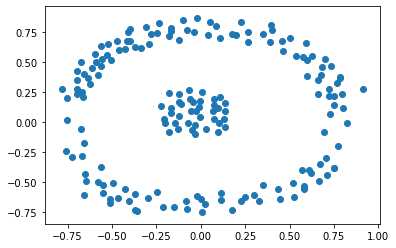

In [15]:
plt.scatter(eye['X'], eye['Y'])

In [ ]:
def kmeans(data,init_centers,k):
    max_step = 50 #定义迭代次数
    epsilon = 0.001 #定义足够小的数来判断中心点位置是否变化

    old_centers = init_centers
    centers_container = [] #建立一个中心点容器，存放每一次变化后的中心点，以便后面的绘图
    cluster_container = []
    centers_container.append(old_centers)

    for step in range(max_step):#每一次迭代
        clusters = np.array([],dtype=int)#每一个样本点归的类
        for each_data in data:
            distances = np.array([])
            for each_center in old_centers:#中心点数目
                temp_distance = d_euc(each_data,each_center)#样本到该中心点的欧式距离
                distances = np.append(distances,temp_distance)
            lab = np.argmin(distances)#判断距离each_data最近的中心点#???牵引回来的是什么
            clusters = np.append(clusters,lab)#
        cluster_container.append(clusters)
        new_centers = update_center(clusters,data,old_centers)

        #减少多余迭代，如果都不需要更新了就不需要再迭代了，减少时间
        difference = []
        for each_old_center,each_new_center in zip(old_centers,new_centers):
            difference.append(d_euc(each_old_center,each_new_center))

        if(np.array(difference) < epsilon).all():
            return centers_container, cluster_container

        centers_container.append(new_centers)
        old_centers = new_centers

    return centers_container, cluster_container